# Eksperimen BERT untuk Klasifikasi Emosi Ekman
## 6 Model Binary Classification vs Baseline Multi-class

**Tujuan Eksperimen:**
1. Melatih 6 model BERT terpisah (satu per emosi Ekman)
2. Setiap model melakukan binary classification (emotion vs non-emotion)
3. Membandingkan performa dengan baseline multi-class BERT
4. **TRAINING PADA ORIGINAL DATASET (TANPA BALANCING)**

**Arsitektur Model:**
- BERT base-uncased
- 12 layer transformer
- 12 attention heads
- Hidden size 768

**Hyperparameter (Fixed - No Tuning):**
- Learning rate: 2e-5
- Batch size: 32
- Epochs: 50
- Optimizer: AdamW dengan weight decay 0.01

**Dataset:**
- Training: train.tsv
- Development: dev.tsv
- Testing: test.tsv

**Emosi Ekman (6 + Neutral):**
- Anger
- Disgust
- Fear
- Joy
- Sadness
- Surprise
- Neutral (akan di-exclude dari 6 model binary)

In [ ]:
# Setup: Install dependencies dan import libraries
import sys
import subprocess

# Install required packages
packages = [
    'transformers',
    'torch',
    'scikit-learn',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'graphviz',
    'nltk',
    'Sastrawi',
    'contractions',
    'clean-text'
]

print("Installing required packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("✓ All packages installed successfully!")

# Import libraries
import pandas as pd
import numpy as np
import json
import os
import warnings
import re
from collections import Counter
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK for stopwords and tokenization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sastrawi for Indonesian stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Text Preprocessing Libraries
import contractions
from cleantext import clean

warnings.filterwarnings('ignore')

# Download NLTK data
print("\nDownloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("✓ NLTK data downloaded")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create results directory
os.makedirs('results', exist_ok=True)
print("✓ Results directory created")

Installing required packages...
✓ All packages installed successfully!
✓ All packages installed successfully!


✓ NLTK data downloaded

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.88 GB
✓ Results directory created
✓ NLTK data downloaded

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.88 GB
✓ Results directory created


STEP 1: LOADING DATA & EKMAN MAPPING
✓ Loaded 28 original emotions
✓ Mapped to 7 Ekman categories
  Ekman emotions: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

Loading datasets...
✓ Train set: 43,410 samples
✓ Dev set: 5,426 samples
✓ Test set: 5,427 samples

Ekman emotion distribution in training set:
  anger     : 5,316 (12.25%)
  disgust   :   579 ( 1.33%)
  fear      :   618 ( 1.42%)
  joy       : 16,941 (39.03%)
  sadness   : 2,648 ( 6.10%)
  surprise  : 4,485 (10.33%)
  neutral   : 12,823 (29.54%)


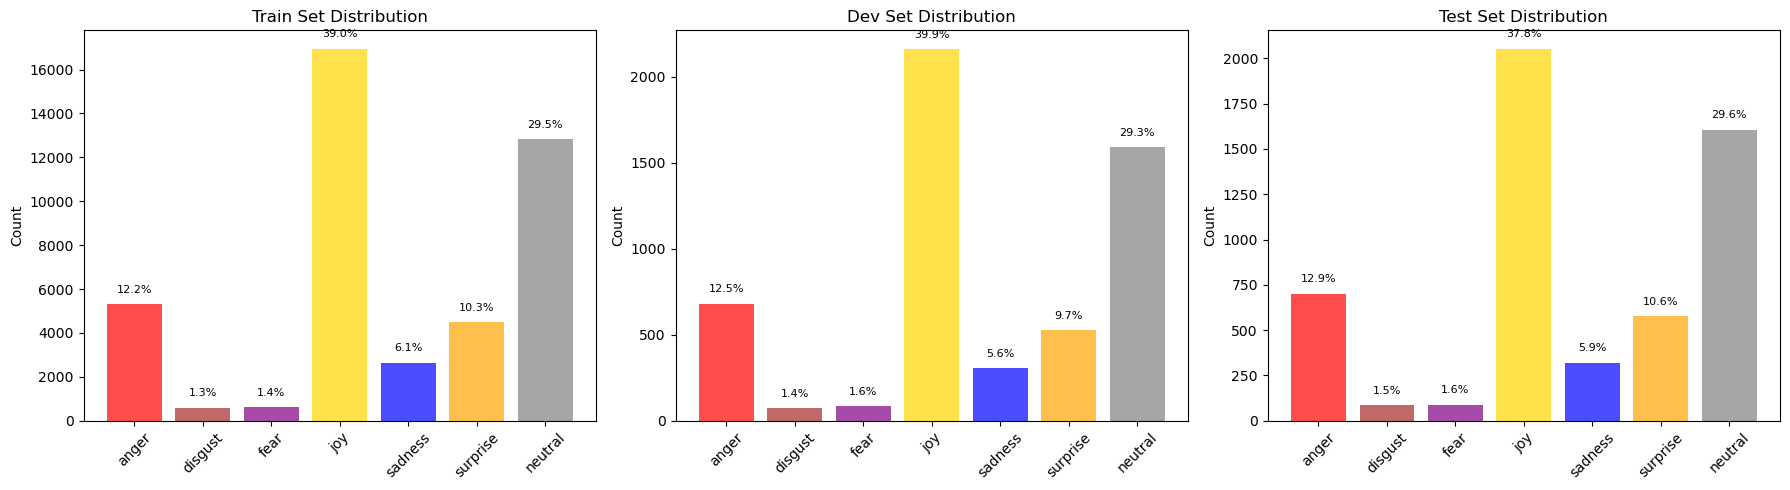


✓ Distribution plot saved t results/original_distribution.ng


In [2]:
# Step 1: Load Data dan Mapping ke Ekman Emotions
print("="*60)
print("STEP 1: LOADING DATA & EKMAN MAPPING")
print("="*60)

# Path ke data (sesuaikan dengan struktur folder Anda)
DATA_PATH = r'../data/'

# Load emotion mappings
with open(f'{DATA_PATH}emotions.txt', 'r', encoding='utf-8') as f:
    emotions = [line.strip() for line in f]

with open(f'{DATA_PATH}ekman_mapping.json', 'r', encoding='utf-8') as f:
    ekman_mapping = json.load(f)

# Create reverse mapping
idx_to_emotion = {i: emotion for i, emotion in enumerate(emotions)}
emotion_to_ekman = {}
for ekman_cat, emotion_list in ekman_mapping.items():
    for emotion in emotion_list:
        emotion_to_ekman[emotion] = ekman_cat
emotion_to_ekman['neutral'] = 'neutral'

print(f"✓ Loaded {len(emotions)} original emotions")
print(f"✓ Mapped to {len(set(emotion_to_ekman.values()))} Ekman categories")
print(f"  Ekman emotions: {sorted(set(emotion_to_ekman.values()))}")

def map_labels_to_ekman(label_str):
    """Map original labels to Ekman emotions with multi-label handling"""
    if ',' in str(label_str):
        # Multi-label: majority vote
        indices = [int(x) for x in str(label_str).split(',')]
        ekman_labels = [emotion_to_ekman.get(idx_to_emotion[idx], 'unknown') for idx in indices]
        counter = Counter(ekman_labels)
        return counter.most_common(1)[0][0]
    else:
        # Single label
        idx = int(label_str)
        emotion = idx_to_emotion[idx]
        return emotion_to_ekman.get(emotion, 'unknown')

def load_data(path):
    """Load TSV data and map to Ekman emotions"""
    df = pd.read_csv(path, sep='\t', header=None, names=['text', 'labels', 'id'])
    df['ekman'] = df['labels'].apply(map_labels_to_ekman)
    return df

# Load datasets
print("\nLoading datasets...")
train_df = load_data(f'{DATA_PATH}train.tsv')
dev_df = load_data(f'{DATA_PATH}dev.tsv')
test_df = load_data(f'{DATA_PATH}test.tsv')

print(f"✓ Train set: {len(train_df):,} samples")
print(f"✓ Dev set: {len(dev_df):,} samples")
print(f"✓ Test set: {len(test_df):,} samples")

# Display distribution
ekman_categories = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
print("\nEkman emotion distribution in training set:")
train_dist = train_df['ekman'].value_counts()
for emotion in ekman_categories:
    count = train_dist.get(emotion, 0)
    pct = (count / len(train_df)) * 100
    print(f"  {emotion:10s}: {count:5,} ({pct:5.2f}%)")

# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'brown', 'purple', 'gold', 'blue', 'orange', 'gray']

for i, (name, df) in enumerate([('Train', train_df), ('Dev', dev_df), ('Test', test_df)]):
    counts = df['ekman'].value_counts().reindex(ekman_categories, fill_value=0)
    axes[i].bar(ekman_categories, counts, color=colors, alpha=0.7)
    axes[i].set_title(f'{name} Set Distribution')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

    # Add percentage labels
    total = len(df)
    for j, count in enumerate(counts):
        if count > 0:
            pct = (count / total) * 100
            axes[i].text(j, count + total*0.01, f'{pct:.1f}%',
                        ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('results/original_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Distribution plot saved t results/original_distribution.ng")

STEP 1.5: TEXT PREPROCESSING PIPELINE
Pipeline: Case Folding → Cleaning → Normalization → Stopword Removal → Stemming

Applying preprocessing to datasets...
  - Case Folding (lowercase)
  - Cleaning (remove URLs, mentions, numbers, special chars)
  - Normalization (expand contractions and slang)
  - Stopword Removal (English stopwords)
  - Stemming (optional, currently disabled to preserve emotion words)

✓ Preprocessing complete!

PREPROCESSING EXAMPLES (Before → After)

[NEUTRAL]
Original    : My favourite food is anything I didn't have to cook myself....
Preprocessed: favourit food anyth cook...

[JOY]
Original    : You just make her sound awesome....
Preprocessed: make sound awesom...

[NEUTRAL]
Original    : I was actually a little lost here and there for an episode or two because I didn't remember everythi...
Preprocessed: actual littl lost episod two rememb everyth season came back though...

[JOY]
Original    : I changed from [NAME] to [NAME] last night because I panicked. I am

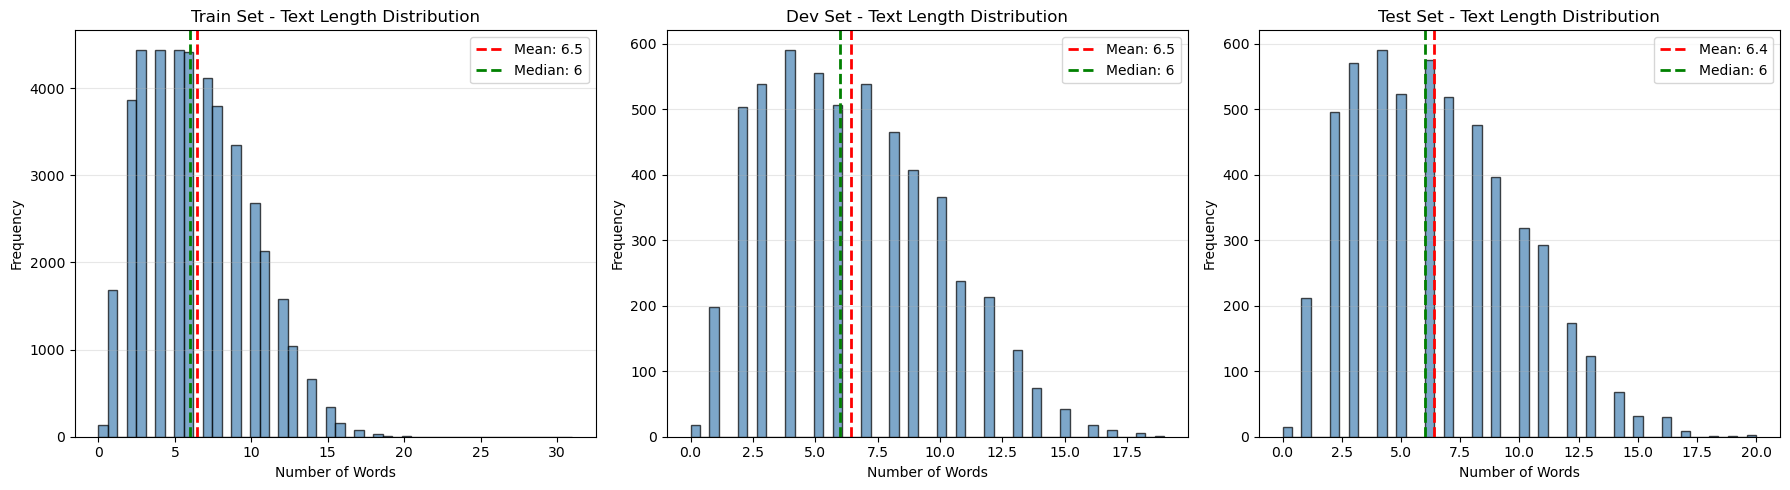


✓ Text length distribution plot saved to results/text_length_distribution.png


In [ ]:
# Step 1.5: Text Preprocessing Pipeline
print("="*60)
print("STEP 1.5: TEXT PREPROCESSING PIPELINE")
print("="*60)
print("Pipeline: Normalization (Library) → Cleaning (Library) → Stopword Removal → Stemming\n")

# Initialize stemmer and stopwords
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Complete preprocessing pipeline using libraries:
    1. Normalization (expand contractions) - using contractions library
    2. Cleaning (lowercase, remove URLs, emails, numbers, punct) - using clean-text library
    3. Stopword Removal
    4. Stemming
    """
    if not isinstance(text, str):
        text = str(text)
    
    # 1. NORMALIZATION: Expand contractions
    # We do this first so "don't" becomes "do not" before punctuation removal
    # Using 'contractions' library instead of manual dictionary
    text = contractions.fix(text)
    
    # 2. CLEANING & CASE FOLDING
    # Using 'clean-text' library instead of manual regex
    text = clean(text,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks
        no_urls=True,                  # remove URLs
        no_emails=True,                # remove email addresses
        no_phone_numbers=True,         # remove phone numbers
        no_numbers=True,               # remove numbers
        no_digits=True,                # remove digits
        no_currency_symbols=True,      # remove currency symbols
        no_punct=True,                 # remove punctuations
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"
    )
    
    # 3. STOPWORD REMOVAL
    try:
        tokens = word_tokenize(text)
    except:
        # Fallback to simple split if tokenization fails
        tokens = text.split()
    
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # 4. STEMMING (using Sastrawi for general purpose)
    # Note: Sastrawi is for Indonesian, for English you might want to use PorterStemmer
    # For this dataset (English GoEmotions), we'll use a simple approach
    # You can uncomment the stemming line below if needed
    # stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # For English text, we'll skip stemming to preserve emotion keywords
    # Uncomment below for stemming:
    from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    filtered_tokens = [porter.stem(word) for word in filtered_tokens]
    
    # Join tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

# Apply preprocessing to all datasets
print("Applying preprocessing to datasets...")
print("  - Normalization (contractions library)")
print("  - Cleaning (clean-text library)")
print("  - Stopword Removal (English stopwords)")
print("  - Stemming (PorterStemmer)\n")

# Store original text for comparison
train_df['text_original'] = train_df['text'].copy()
dev_df['text_original'] = dev_df['text'].copy()
test_df['text_original'] = test_df['text'].copy()

# Apply preprocessing
train_df['text'] = train_df['text'].apply(preprocess_text)
dev_df['text'] = dev_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

print("✓ Preprocessing complete!")

# Show examples of preprocessing
print("\n" + "="*80)
print("PREPROCESSING EXAMPLES")
print("="*80)
for i in range(5):
    print(f"Original: {train_df['text_original'].iloc[i]}")
    print(f"Cleaned : {train_df['text'].iloc[i]}")
    print("-" * 50)

STEP 2: CREATING BINARY DATASETS (6 EMOTIONS)
⚠️ Using preprocessed text from Step 1.5


Creating binary dataset for: ANGER
  Train: 5,316 positive, 38,094 negative
  Ratio: 1:7.17 (positive:negative)

Creating binary dataset for: DISGUST
  Train: 579 positive, 42,831 negative
  Ratio: 1:73.97 (positive:negative)

Creating binary dataset for: FEAR
  Train: 618 positive, 42,792 negative
  Ratio: 1:69.24 (positive:negative)

Creating binary dataset for: JOY
  Train: 16,941 positive, 26,469 negative
  Ratio: 1:1.56 (positive:negative)

Creating binary dataset for: SADNESS
  Train: 2,648 positive, 40,762 negative
  Ratio: 1:15.39 (positive:negative)

Creating binary dataset for: SURPRISE
  Train: 4,485 positive, 38,925 negative
  Ratio: 1:8.68 (positive:negative)

✓ Created binary datasets for 6 emotions


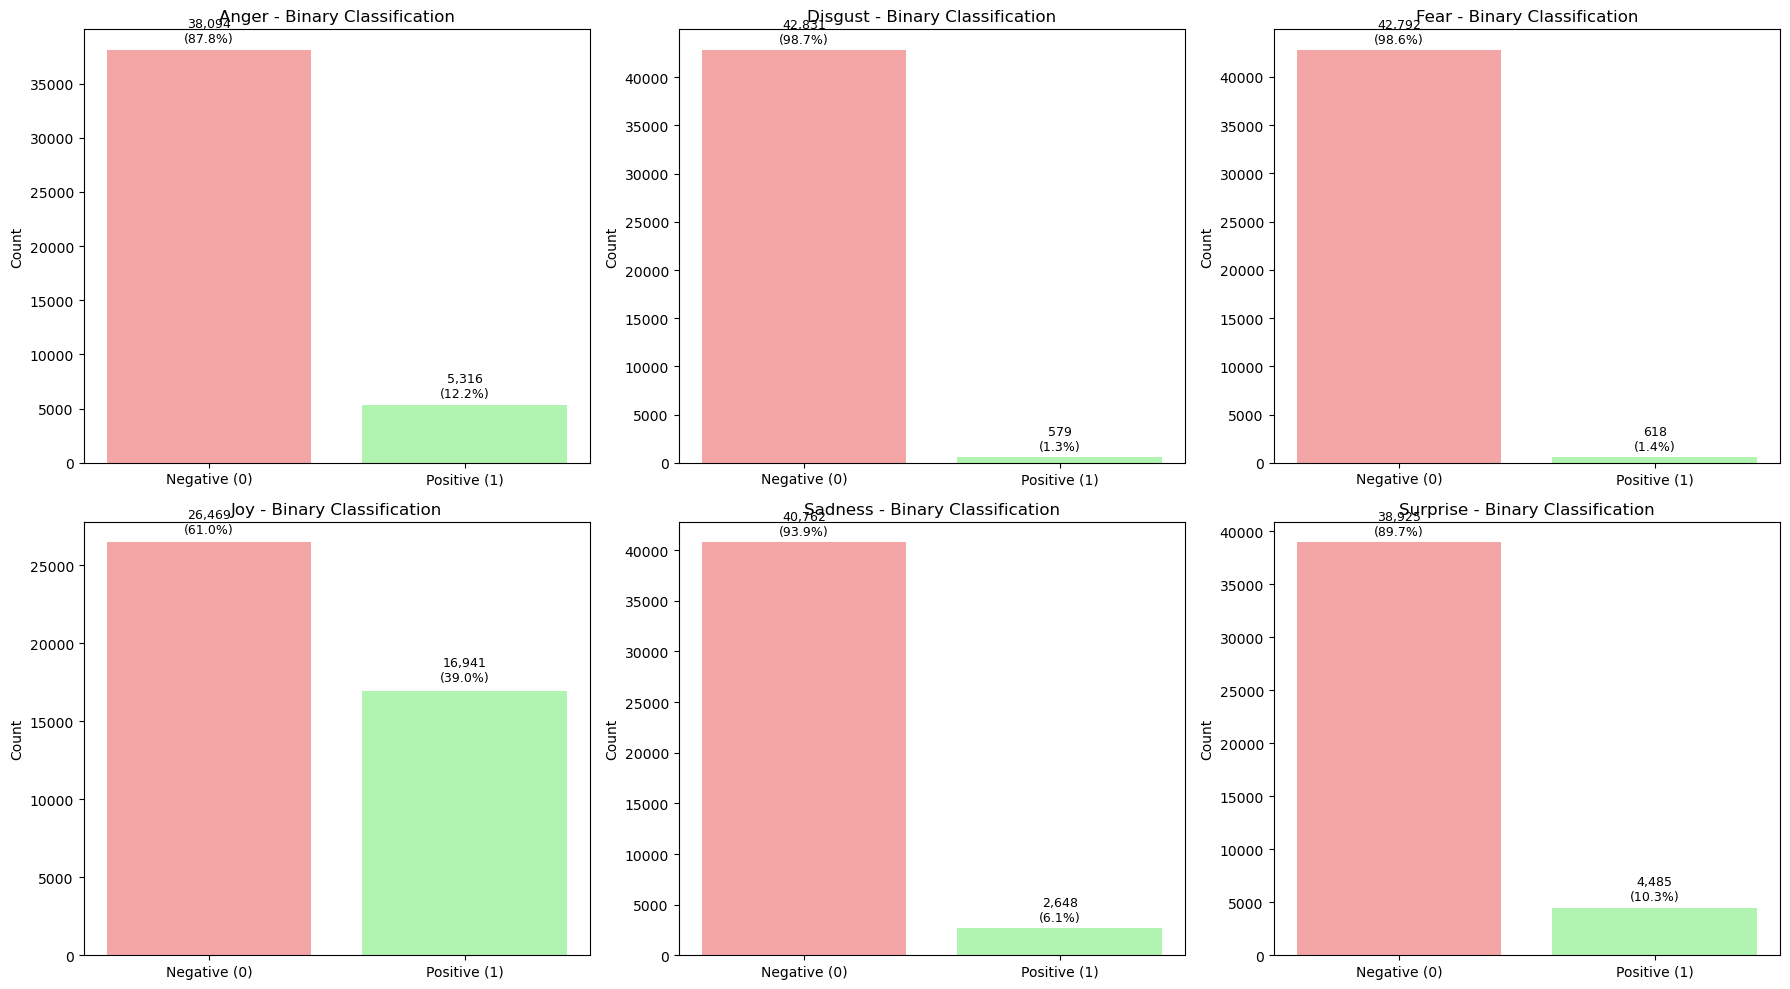


✓ Class imbalance plot saved to results/binary_class_imbalance.png

⚠️ NOTE: Training will use ORIGINAL IMBALANCED data (NO SMOTE/balancing)


In [4]:
# Step 2: Create Binary Datasets untuk setiap Ekman Emotion
print("="*60)
print("STEP 2: CREATING BINARY DATASETS (6 EMOTIONS)")
print("="*60)
print("⚠️ Using preprocessed text from Step 1.5\n")

# Exclude 'neutral' dari 6 model binary (fokus pada 6 emosi Ekman saja)
target_emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

def create_binary_dataset(df, emotion):
    """Create binary classification dataset for one emotion"""
    df_bin = df.copy()
    df_bin['label'] = (df_bin['ekman'] == emotion).astype(int)
    return df_bin

# Create binary datasets untuk setiap emosi
binary_datasets = {}

for emotion in target_emotions:
    print(f"\nCreating binary dataset for: {emotion.upper()}")

    train_bin = create_binary_dataset(train_df, emotion)
    dev_bin = create_binary_dataset(dev_df, emotion)
    test_bin = create_binary_dataset(test_df, emotion)

    # Count distribution
    train_pos = (train_bin['label'] == 1).sum()
    train_neg = (train_bin['label'] == 0).sum()

    print(f"  Train: {train_pos:,} positive, {train_neg:,} negative")
    print(f"  Ratio: 1:{train_neg/train_pos:.2f} (positive:negative)")

    binary_datasets[emotion] = {
        'train': train_bin,
        'dev': dev_bin,
        'test': test_bin,
        'original_ratio': train_neg / train_pos
    }

print(f"\n✓ Created binary datasets for {len(target_emotions)} emotions")

# Visualize class imbalance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, emotion in enumerate(target_emotions):
    train_bin = binary_datasets[emotion]['train']
    counts = train_bin['label'].value_counts().sort_index()

    axes[i].bar(['Negative (0)', 'Positive (1)'], counts.values,
                color=['lightcoral', 'lightgreen'], alpha=0.7)
    axes[i].set_title(f'{emotion.capitalize()} - Binary Classification')
    axes[i].set_ylabel('Count')

    # Add count labels
    for j, count in enumerate(counts.values):
        pct = (count / len(train_bin)) * 100
        axes[i].text(j, count + len(train_bin)*0.01,
                    f'{count:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('results/binary_class_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Class imbalance plot saved to results/binary_class_imbalance.png")
print("\n⚠️ NOTE: Training will use ORIGINAL IMBALANCED data (NO SMOTE/balancing)")

In [5]:
# Step 3: BERT Dataset Class dan DataLoader Setup
print("="*60)
print("STEP 3: BERT DATASET & DATALOADER SETUP")
print("="*60)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("✓ Tokenizer loaded: bert-base-uncased")

class BertEmotionDataset(Dataset):
    """BERT Dataset for emotion classification"""
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loaders(df_train, df_dev, df_test, tokenizer, batch_size=16):
    """Create DataLoaders for train, dev, and test sets"""
    train_dataset = BertEmotionDataset(
        texts=df_train['text'].values,
        labels=df_train['label'].values,
        tokenizer=tokenizer
    )

    dev_dataset = BertEmotionDataset(
        texts=df_dev['text'].values,
        labels=df_dev['label'].values,
        tokenizer=tokenizer
    )

    test_dataset = BertEmotionDataset(
        texts=df_test['text'].values,
        labels=df_test['label'].values,
        tokenizer=tokenizer
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, dev_loader, test_loader

print("✓ BERT Dataset class defined")
print("✓ DataLoader creation function ready")

STEP 3: BERT DATASET & DATALOADER SETUP
✓ Tokenizer loaded: bert-base-uncased
✓ BERT Dataset class defined
✓ DataLoader creation function ready
✓ Tokenizer loaded: bert-base-uncased
✓ BERT Dataset class defined
✓ DataLoader creation function ready


In [6]:
# Step 5: Training Functions (Fixed Hyperparameters - No Tuning)
print("="*60)
print("STEP 5: TRAINING FUNCTIONS (FIXED HYPERPARAMETERS)")
print("="*60)

import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Fixed hyperparameters berdasarkan literatur
FIXED_PARAMS = {
    'learning_rate': 2e-5,
    'batch_size': 32,
    'epochs': 50,
    'weight_decay': 0.01
}

print(f"Fixed Hyperparameters:")
print(f"  Learning Rate: {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size: {FIXED_PARAMS['batch_size']}")
print(f"  Epochs: {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay: {FIXED_PARAMS['weight_decay']}")
print(f"  Optimizer: AdamW")
print(f"  Architecture: BERT (12 layers, 12 heads, hidden=768)")

# -------------------------------------------------------------
# ✅ Training Loop with AMP and Memory Optimization
# -------------------------------------------------------------
def train_epoch_amp(model, data_loader, optimizer, scheduler, device, scaler):
    """Training loop with automatic mixed precision"""
    model.train()
    total_loss = 0.0
    predictions, true_labels = [], []

    for batch in data_loader:
        optimizer.zero_grad(set_to_none=True)

        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        with autocast():  # mixed precision
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.detach().cpu().numpy())

        del input_ids, attention_mask, labels, outputs, logits
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    return avg_loss, accuracy


# -------------------------------------------------------------
# ✅ Evaluation Function (No Grad + AMP)
# -------------------------------------------------------------
def evaluate_model_amp(model, data_loader, device):
    """Evaluation with automatic mixed precision"""
    model.eval()
    predictions, true_labels, probabilities = [], [], []

    with torch.no_grad(), autocast():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs[:, 1].cpu().numpy())

            del input_ids, attention_mask, labels, outputs, logits, probs
            torch.cuda.empty_cache()

    acc = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary', zero_division=0)
    try:
        roc_auc = roc_auc_score(true_labels, probabilities)
    except ValueError:
        roc_auc = 0.0

    return {
        'accuracy': acc, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'roc_auc': roc_auc,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities
    }


# -------------------------------------------------------------
# ✅ Training Function with Fixed Hyperparameters
# -------------------------------------------------------------
def train_bert_model_fixed(train_loader, dev_loader, test_loader, device, emotion_name, params=FIXED_PARAMS):
    """Train BERT model with fixed hyperparameters (no tuning)"""
    print(f"\n{'='*60}")
    print(f"🧠 Training {emotion_name.upper()}")
    print(f"{'='*60}")
    print(f"Parameters: LR={params['learning_rate']}, Batch={params['batch_size']}, "
          f"Epochs={params['epochs']}, Weight Decay={params['weight_decay']}")

    # Initialize BERT model (12 layers, 12 heads, hidden=768)
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
    
    # AdamW optimizer with weight decay
    optimizer = AdamW(
        model.parameters(), 
        lr=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        eps=1e-8
    )
    
    # Learning rate scheduler
    total_steps = len(train_loader) * params['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=total_steps
    )
    
    # Mixed precision scaler
    scaler = GradScaler()

    best_f1, best_epoch = 0, 0
    best_dev_metrics = None
    best_model_state = None
    
    # Track training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_f1': [],
        'dev_acc': []
    }

    print(f"\nStarting training for {params['epochs']} epochs...")
    print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Dev F1':<12} {'Dev Acc':<12} {'Status'}")
    print("-" * 70)

    for epoch in range(params['epochs']):
        # Training
        train_loss, train_acc = train_epoch_amp(model, train_loader, optimizer, scheduler, device, scaler)
        
        # Validation
        dev_metrics = evaluate_model_amp(model, dev_loader, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['dev_f1'].append(dev_metrics['f1'])
        history['dev_acc'].append(dev_metrics['accuracy'])
        
        # Track best model
        status = ""
        if dev_metrics['f1'] > best_f1:
            best_f1 = dev_metrics['f1']
            best_epoch = epoch + 1
            best_dev_metrics = dev_metrics
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            status = "⭐ BEST"
        
        # Print progress every 5 epochs or if best
        if (epoch + 1) % 5 == 0 or status:
            print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} "
                  f"{dev_metrics['f1']:<12.4f} {dev_metrics['accuracy']:<12.4f} {status}")
        
        torch.cuda.empty_cache()

    print("-" * 70)
    print(f"✓ Training completed! Best epoch: {best_epoch} (Dev F1: {best_f1:.4f})")

    # Load best model from memory
    if best_model_state:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    # Evaluate on test set
    print(f"\nEvaluating on test set...")
    test_metrics = evaluate_model_amp(model, test_loader, device)

    # Save model
    os.makedirs('results', exist_ok=True)
    model_path = f"results/best_model_{emotion_name}.pt"
    torch.save(best_model_state, model_path)
    print(f"✓ Model saved to {model_path}")

    return {
        'emotion': emotion_name,
        'params': params,
        'best_epoch': best_epoch,
        'dev_metrics': best_dev_metrics,
        'test_metrics': test_metrics,
        'history': history,
        'model': model
    }


print("\n✓ Training functions ready (Fixed hyperparameters, no tuning)")


# -------------------------------------------------------------
# Step 6: Train All 6 Binary Models
# -------------------------------------------------------------
print("\n" + "="*60)
print("STEP 6: TRAIN 6 BINARY MODELS (FIXED HYPERPARAMETERS)")
print("="*60)
print(f"⚠️ Using ORIGINAL dataset (NO balancing/SMOTE)")
print(f"⚠️ Fixed hyperparameters (NO tuning/grid search)")

all_results = {}
best_models_per_emotion = {}

for emotion in target_emotions:
    print(f"\n{'='*60}")
    print(f"TRAINING: {emotion.upper()}")
    print(f"{'='*60}")

    # Use ORIGINAL unbalanced data
    train_data = binary_datasets[emotion]['train']
    dev_data = binary_datasets[emotion]['dev']
    test_data = binary_datasets[emotion]['test']
    
    print(f"Dataset Statistics:")
    print(f"  Train samples: {len(train_data):,}")
    print(f"  Positive class: {(train_data['label']==1).sum():,} ({(train_data['label']==1).sum()/len(train_data)*100:.1f}%)")
    print(f"  Negative class: {(train_data['label']==0).sum():,} ({(train_data['label']==0).sum()/len(train_data)*100:.1f}%)")

    # Create data loaders with FIXED batch size
    train_loader, dev_loader, test_loader = create_data_loaders(
        train_data, dev_data, test_data, 
        tokenizer, 
        batch_size=FIXED_PARAMS['batch_size']
    )

    # Train model with fixed hyperparameters
    result = train_bert_model_fixed(
        train_loader, dev_loader, test_loader, 
        device, emotion
    )

    # Store results
    all_results[emotion] = result
    best_models_per_emotion[emotion] = {
        'params': result['params'],
        'best_epoch': result['best_epoch'],
        'dev_metrics': result['dev_metrics'],
        'test_metrics': result['test_metrics']
    }
    
    # Clean up
    del result['model']
    torch.cuda.empty_cache()
    
    print(f"\n✓ {emotion.upper()} completed!")
    print(f"  Best Epoch: {result['best_epoch']}")
    print(f"  Dev F1: {result['dev_metrics']['f1']:.4f}")
    print(f"  Test F1: {result['test_metrics']['f1']:.4f}")
    print(f"  Test Precision: {result['test_metrics']['precision']:.4f}")
    print(f"  Test Recall: {result['test_metrics']['recall']:.4f}")
    print(f"  Test ROC-AUC: {result['test_metrics']['roc_auc']:.4f}")

print(f"\n{'='*80}")
print("SUMMARY: BINARY MODELS RESULTS")
print(f"{'='*80}")
print(f"{'Emotion':<12} {'Best Epoch':<12} {'Dev F1':<10} {'Test F1':<10} {'Test Prec':<10} {'Test Rec':<10} {'ROC-AUC':<10}")
print("-" * 80)
for emotion, result in best_models_per_emotion.items():
    print(f"{emotion.capitalize():<12} {result['best_epoch']:<12} "
          f"{result['dev_metrics']['f1']:<10.4f} {result['test_metrics']['f1']:<10.4f} "
          f"{result['test_metrics']['precision']:<10.4f} {result['test_metrics']['recall']:<10.4f} "
          f"{result['test_metrics']['roc_auc']:<10.4f}")
print("-" * 80)


STEP 5: TRAINING FUNCTIONS (FIXED HYPERPARAMETERS)
Fixed Hyperparameters:
  Learning Rate: 2e-05
  Batch Size: 32
  Epochs: 50
  Weight Decay: 0.01
  Optimizer: AdamW
  Architecture: BERT (12 layers, 12 heads, hidden=768)

✓ Training functions ready (Fixed hyperparameters, no tuning)

STEP 6: TRAIN 6 BINARY MODELS (FIXED HYPERPARAMETERS)
⚠️ Using ORIGINAL dataset (NO balancing/SMOTE)
⚠️ Fixed hyperparameters (NO tuning/grid search)

TRAINING: ANGER
Dataset Statistics:
  Train samples: 43,410
  Positive class: 5,316 (12.2%)
  Negative class: 38,094 (87.8%)

🧠 Training ANGER
Parameters: LR=2e-05, Batch=32, Epochs=50, Weight Decay=0.01


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.3294       0.8818       0.3764       0.8833       ⭐ BEST
1        0.3294       0.8818       0.3764       0.8833       ⭐ BEST
2        0.2906       0.8900       0.4093       0.8878       ⭐ BEST
2        0.2906       0.8900       0.4093       0.8878       ⭐ BEST
4        0.2505       0.9039       0.4156       0.8870       ⭐ BEST
4        0.2505       0.9039       0.4156       0.8870       ⭐ BEST
5        0.2062       0.9223       0.4108       0.8752       
5        0.2062       0.9223       0.4108       0.8752       
6        0.1622       0.9406       0.4234       0.8655       ⭐ BEST
6        0.1622       0.9406       0.4234       0.8655       ⭐ BEST
10       0.1177       0.9724       0.4230       0.8612       
10       0.1177       0.9724       0.4230       0.8612       
15       0.1244       0.9863     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
3        0.1746       0.9873       0.3878       0.9889       ⭐ BEST
3        0.1746       0.9873       0.3878       0.9889       ⭐ BEST
4        0.1516       0.9882       0.3918       0.9891       ⭐ BEST
4        0.1516       0.9882       0.3918       0.9891       ⭐ BEST
5        0.1416       0.9886       0.4769       0.9875       ⭐ BEST
5        0.1416       0.9886       0.4769       0.9875       ⭐ BEST
10       0.0250       0.9977       0.4085       0.9845       
10       0.0250       0.9977       0.4085       0.9845       
11       0.0256       0.9975       0.4874       0.9888       ⭐ BEST
11       0.0256       0.9975       0.4874       0.9888       ⭐ BEST
15       0.0089       0.9992       0.4032       0.9864       
15       0.0089       0.9992       0.4032       0.9864       
20       0.0066       0.9994     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
3        0.1250       0.9874       0.4615       0.9858       ⭐ BEST
3        0.1250       0.9874       0.4615       0.9858       ⭐ BEST
4        0.1106       0.9891       0.4895       0.9865       ⭐ BEST
4        0.1106       0.9891       0.4895       0.9865       ⭐ BEST
5        0.1001       0.9904       0.5000       0.9864       ⭐ BEST
5        0.1001       0.9904       0.5000       0.9864       ⭐ BEST
10       0.0086       0.9992       0.4857       0.9867       
10       0.0086       0.9992       0.4857       0.9867       
15       0.0073       0.9993       0.4583       0.9856       
15       0.0073       0.9993       0.4583       0.9856       
20       0.0021       0.9998       0.4503       0.9847       
20       0.0021       0.9998       0.4503       0.9847       
25       0.0022       0.9998       0.4648    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.4837       0.7809       0.7710       0.8260       ⭐ BEST
1        0.4837       0.7809       0.7710       0.8260       ⭐ BEST
2        0.4079       0.8295       0.7802       0.8334       ⭐ BEST
2        0.4079       0.8295       0.7802       0.8334       ⭐ BEST
3        0.3850       0.8405       0.7852       0.8303       ⭐ BEST
3        0.3850       0.8405       0.7852       0.8303       ⭐ BEST
5        0.3471       0.8561       0.7765       0.8317       
5        0.3471       0.8561       0.7765       0.8317       
10       0.2299       0.9130       0.7674       0.8225       
10       0.2299       0.9130       0.7674       0.8225       
15       0.1102       0.9638       0.7581       0.7971       
15       0.1102       0.9638       0.7581       0.7971       
20       0.1693       0.9745       0.7502    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.2039       0.9392       0.5000       0.9528       ⭐ BEST
1        0.2039       0.9392       0.5000       0.9528       ⭐ BEST
2        0.1531       0.9506       0.5174       0.9539       ⭐ BEST
2        0.1531       0.9506       0.5174       0.9539       ⭐ BEST
5        0.1331       0.9716       0.4762       0.9432       
5        0.1331       0.9716       0.4762       0.9432       
10       0.0842       0.9920       0.4487       0.9475       
10       0.0842       0.9920       0.4487       0.9475       
15       0.0369       0.9965       0.4638       0.9467       
15       0.0369       0.9965       0.4638       0.9467       
20       0.0180       0.9982       0.4280       0.9488       
20       0.0180       0.9982       0.4280       0.9488       
25       0.0158       0.9983       0.4462       0.9497   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.3173       0.8955       0.1426       0.9069       ⭐ BEST
1        0.3173       0.8955       0.1426       0.9069       ⭐ BEST
2        0.2767       0.9033       0.1867       0.9101       ⭐ BEST
2        0.2767       0.9033       0.1867       0.9101       ⭐ BEST
3        0.2576       0.9081       0.2384       0.9093       ⭐ BEST
3        0.2576       0.9081       0.2384       0.9093       ⭐ BEST
4        0.2296       0.9166       0.2876       0.9014       ⭐ BEST
4        0.2296       0.9166       0.2876       0.9014       ⭐ BEST
5        0.2068       0.9250       0.2785       0.8950       
5        0.2068       0.9250       0.2785       0.8950       
9        0.1194       0.9601       0.2961       0.8896       ⭐ BEST
9        0.1194       0.9601       0.2961       0.8896       ⭐ BEST
10       0.1183      

In [8]:
# Step 7: Train Baseline Multi-class BERT Model (Fixed Hyperparameters)
print("="*60)
print("STEP 7: TRAINING BASELINE MULTI-CLASS BERT")
print("="*60)

# Prepare multi-class dataset (exclude neutral for fair comparison)
train_mc = train_df[train_df['ekman'].isin(target_emotions)].copy()
dev_mc = dev_df[dev_df['ekman'].isin(target_emotions)].copy()
test_mc = test_df[test_df['ekman'].isin(target_emotions)].copy()

# Encode labels
label2id = {emotion: i for i, emotion in enumerate(target_emotions)}
id2label = {i: emotion for emotion, i in label2id.items()}

train_mc['label'] = train_mc['ekman'].map(label2id)
dev_mc['label'] = dev_mc['ekman'].map(label2id)
test_mc['label'] = test_mc['ekman'].map(label2id)

print(f"Multi-class dataset sizes:")
print(f"  Train: {len(train_mc):,} samples")
print(f"  Dev: {len(dev_mc):,} samples")
print(f"  Test: {len(test_mc):,} samples")

print(f"\nClass distribution:")
for emotion in target_emotions:
    count = (train_mc['ekman'] == emotion).sum()
    pct = count / len(train_mc) * 100
    print(f"  {emotion.capitalize():<12}: {count:5,} ({pct:5.1f}%)")

# Use SAME fixed hyperparameters as binary models
print(f"\n{'='*60}")
print(f"Using FIXED hyperparameters (same as binary models):")
print(f"  Learning Rate: {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size: {FIXED_PARAMS['batch_size']}")
print(f"  Epochs: {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay: {FIXED_PARAMS['weight_decay']}")
print(f"{'='*60}")

# Create data loaders
train_loader_mc, dev_loader_mc, test_loader_mc = create_data_loaders(
    train_mc, dev_mc, test_mc,
    tokenizer,
    batch_size=FIXED_PARAMS['batch_size']
)

# Initialize multi-class model (12 layers, 12 heads, hidden=768)
model_mc = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(target_emotions)
)
model_mc = model_mc.to(device)

# AdamW optimizer with weight decay
optimizer_mc = AdamW(
    model_mc.parameters(), 
    lr=FIXED_PARAMS['learning_rate'],
    weight_decay=FIXED_PARAMS['weight_decay'],
    eps=1e-8
)

# Learning rate scheduler
total_steps_mc = len(train_loader_mc) * FIXED_PARAMS['epochs']
scheduler_mc = get_linear_schedule_with_warmup(
    optimizer_mc,
    num_warmup_steps=0,
    num_training_steps=total_steps_mc
)

# Mixed precision scaler
scaler_mc = GradScaler()

# Training loop
print(f"\nStarting multi-class training for {FIXED_PARAMS['epochs']} epochs...")
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Dev Macro-F1':<12} {'Status'}")
print("-" * 60)

best_f1_mc = 0
best_epoch_mc = 0
best_dev_macro_f1 = 0
best_model_state_mc = None

history_mc = {
    'train_loss': [],
    'train_acc': [],
    'dev_macro_f1': []
}

for epoch in range(FIXED_PARAMS['epochs']):
    # Training with AMP
    model_mc.train()
    total_loss = 0.0
    predictions_train = []
    true_labels_train = []

    for batch in train_loader_mc:
        optimizer_mc.zero_grad(set_to_none=True)

        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        with autocast():
            outputs = model_mc(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        scaler_mc.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model_mc.parameters(), 1.0)
        scaler_mc.step(optimizer_mc)
        scaler_mc.update()
        scheduler_mc.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions_train.extend(preds)
        true_labels_train.extend(labels.cpu().numpy())

        del input_ids, attention_mask, labels, outputs, logits
        torch.cuda.empty_cache()

    train_loss = total_loss / len(train_loader_mc)
    train_acc = accuracy_score(true_labels_train, predictions_train)

    # Validation
    model_mc.eval()
    predictions_mc = []
    true_labels_mc = []

    with torch.no_grad(), autocast():
        for batch in dev_loader_mc:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            outputs = model_mc(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            predictions_mc.extend(preds)
            true_labels_mc.extend(labels.cpu().numpy())

            del input_ids, attention_mask, labels, outputs, logits
            torch.cuda.empty_cache()

    # Calculate macro F1 for multi-class
    _, _, f1_macro, _ = precision_recall_fscore_support(
        true_labels_mc, predictions_mc, average='macro', zero_division=0
    )

    # Save history
    history_mc['train_loss'].append(train_loss)
    history_mc['train_acc'].append(train_acc)
    history_mc['dev_macro_f1'].append(f1_macro)

    # Track best model
    status = ""
    if f1_macro > best_f1_mc:
        best_f1_mc = f1_macro
        best_epoch_mc = epoch + 1
        best_dev_macro_f1 = f1_macro
        best_model_state_mc = {k: v.cpu().clone() for k, v in model_mc.state_dict().items()}
        status = "⭐ BEST"

    # Print progress every 5 epochs or if best
    if (epoch + 1) % 5 == 0 or status:
        print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {f1_macro:<12.4f} {status}")

print("-" * 60)
print(f"✓ Multi-class training completed! Best epoch: {best_epoch_mc} (Dev Macro-F1: {best_f1_mc:.4f})")

# Load best model and evaluate on test set
if best_model_state_mc:
    model_mc.load_state_dict({k: v.to(device) for k, v in best_model_state_mc.items()})

print(f"\nEvaluating on test set...")
model_mc.eval()

predictions_test_mc = []
true_labels_test_mc = []

with torch.no_grad(), autocast():
    for batch in test_loader_mc:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        outputs = model_mc(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        predictions_test_mc.extend(preds)
        true_labels_test_mc.extend(labels.cpu().numpy())

        del input_ids, attention_mask, labels, outputs, logits

# Calculate overall test metrics
test_macro_f1 = precision_recall_fscore_support(
    true_labels_test_mc, predictions_test_mc, average='macro', zero_division=0
)[2]

print(f"✓ Test Macro-F1: {test_macro_f1:.4f}")

# Calculate per-class metrics for baseline
print(f"\nPer-emotion performance on test set:")
baseline_metrics = {}
for i, emotion in enumerate(target_emotions):
    # Binary evaluation for each emotion
    true_binary = [1 if label == i else 0 for label in true_labels_test_mc]
    pred_binary = [1 if pred == i else 0 for pred in predictions_test_mc]

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_binary, pred_binary, average='binary', zero_division=0
    )

    baseline_metrics[emotion] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy_score(true_binary, pred_binary)
    }
    
    print(f"  {emotion.capitalize():<12}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# Save baseline model
os.makedirs('results', exist_ok=True)
torch.save(best_model_state_mc, 'results/best_model_multiclass.pt')
print(f"\n✓ Baseline model saved to results/best_model_multiclass.pt")

# Store baseline results
baseline_result = {
    'params': FIXED_PARAMS,
    'best_epoch': best_epoch_mc,
    'dev_macro_f1': best_dev_macro_f1,
    'test_macro_f1': test_macro_f1,
    'per_emotion_metrics': baseline_metrics,
    'history': history_mc
}

print(f"\n{'='*60}")
print("BASELINE MULTI-CLASS MODEL COMPLETED")
print(f"{'='*60}")


STEP 7: TRAINING BASELINE MULTI-CLASS BERT
Multi-class dataset sizes:
  Train: 30,587 samples
  Dev: 3,834 samples
  Test: 3,821 samples

Class distribution:
  Anger       : 5,316 ( 17.4%)
  Disgust     :   579 (  1.9%)
  Fear        :   618 (  2.0%)
  Joy         : 16,941 ( 55.4%)
  Sadness     : 2,648 (  8.7%)
  Surprise    : 4,485 ( 14.7%)

Using FIXED hyperparameters (same as binary models):
  Learning Rate: 2e-05
  Batch Size: 32
  Epochs: 50
  Weight Decay: 0.01


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting multi-class training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev Macro-F1 Status
------------------------------------------------------------
1        1.1107       0.5916       0.4610       ⭐ BEST
2        0.8376       0.6963       0.5862       ⭐ BEST
3        0.7503       0.7309       0.6176       ⭐ BEST
5        0.5887       0.7945       0.5982       
10       0.3218       0.8936       0.5909       
15       0.1662       0.9461       0.5642       
20       0.0778       0.9763       0.5635       
25       0.0786       0.9805       0.5667       
30       0.0879       0.9834       0.5635       
35       0.0750       0.9890       0.5668       
40       0.0610       0.9907       0.5744       
45       0.0483       0.9924       0.5624       
50       0.0440       0.9932       0.5723       
------------------------------------------------------------
✓ Multi-class training completed! Best epoch: 3 (Dev Macro-F1: 0.6176)

Evaluating on test set...
✓ Test Macro-F1: 0.620

STEP 8: RESULTS COMPARISON & VISUALIZATION
✓ Results saved to results/metrics_per_emotion.csv

COMPARISON: BINARY MODELS vs BASELINE (FIXED HYPERPARAMETERS)
 Emotion                Model  Best Epoch  F1-Score  Precision   Recall  ROC-AUC  Accuracy      LR  Batch  Epochs  Weight Decay
   Anger          Binary BERT          18  0.417047   0.446982 0.390870 0.774202  0.858854 0.00002     32      50          0.01
   Anger Baseline Multi-class           3  0.585034   0.622186 0.552068      NaN  0.856320 0.00002     32      50          0.01
 Disgust          Binary BERT          11  0.359375   0.522727 0.273810 0.884903  0.984890 0.00002     32      50          0.01
 Disgust Baseline Multi-class           3  0.538462   0.583333 0.500000      NaN  0.981157 0.00002     32      50          0.01
    Fear          Binary BERT           5  0.558442   0.661538 0.483146 0.938821  0.987470 0.00002     32      50          0.01
    Fear Baseline Multi-class           3  0.685083   0.673913 0.696629    

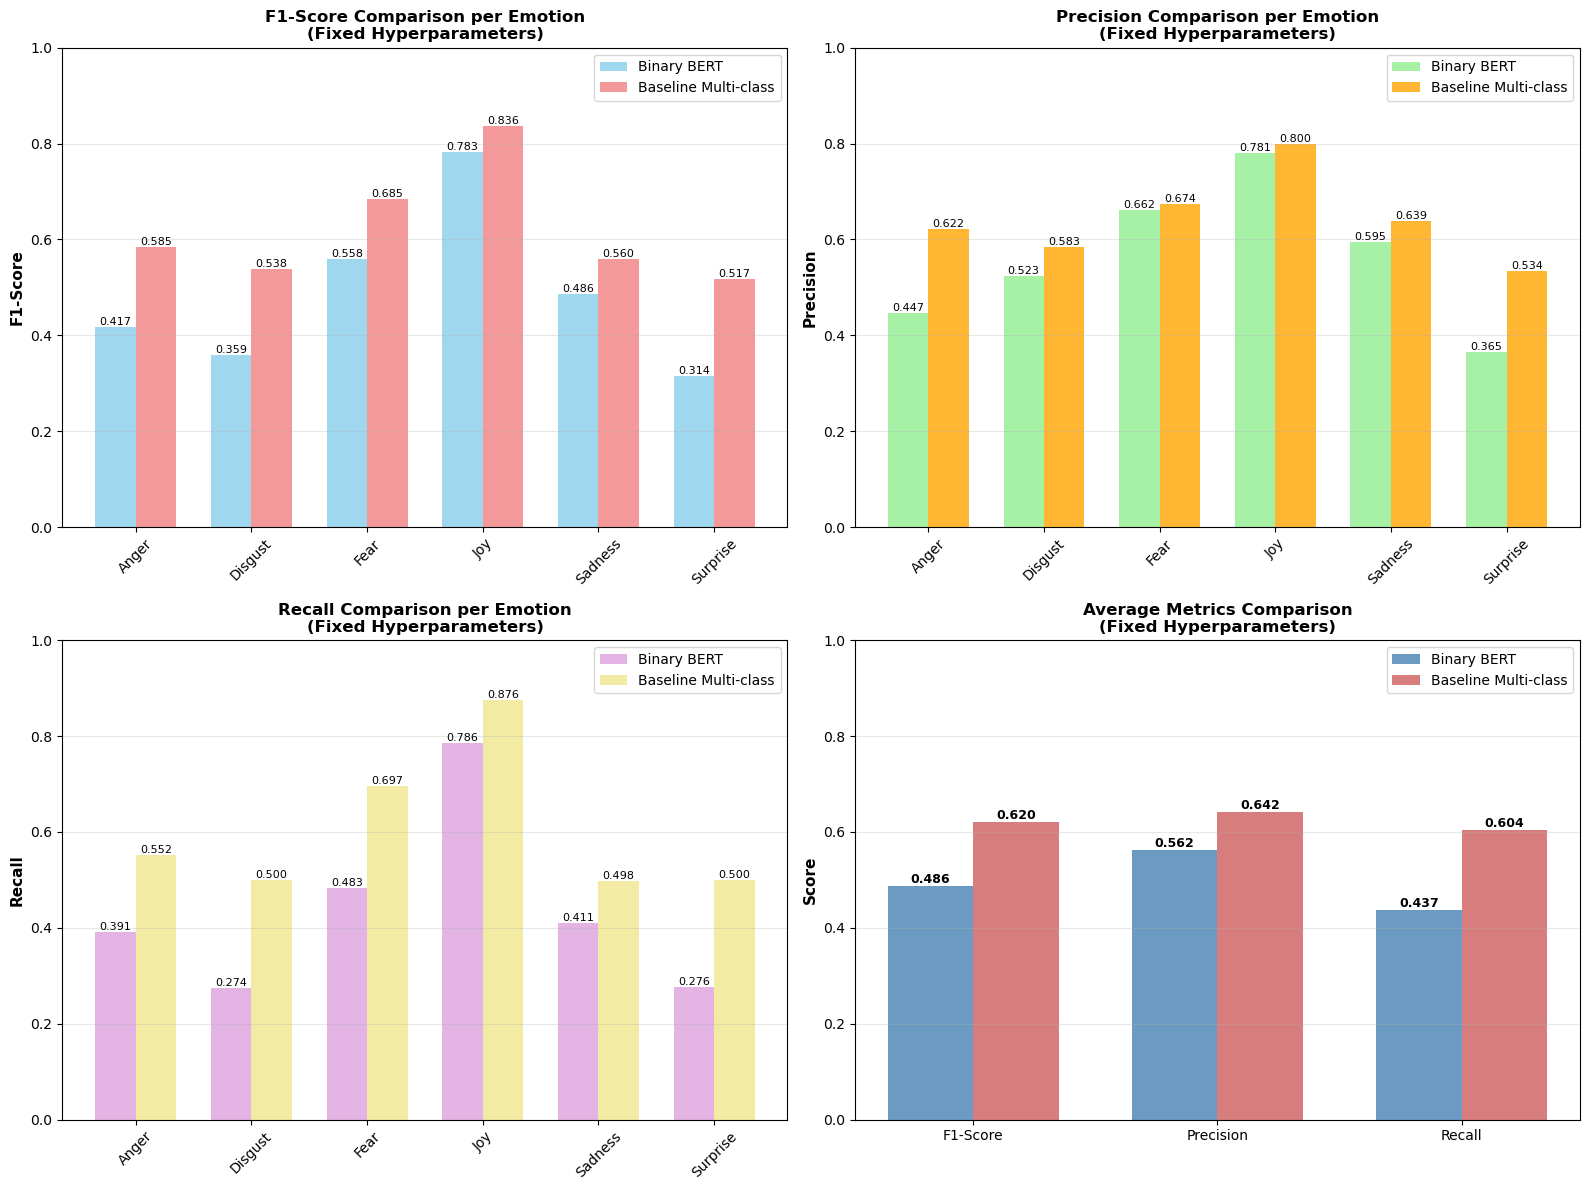


✓ Comparison plot saved to results/comparison_plot.png


In [9]:
# Step 8: Results Comparison & Visualization
print("="*60)
print("STEP 8: RESULTS COMPARISON & VISUALIZATION")
print("="*60)

# Compile results into DataFrame
results_data = []

for emotion in target_emotions:
    best_result = best_models_per_emotion[emotion]

    results_data.append({
        'Emotion': emotion.capitalize(),
        'Model': 'Binary BERT',
        'Best Epoch': best_result['best_epoch'],
        'F1-Score': best_result['test_metrics']['f1'],
        'Precision': best_result['test_metrics']['precision'],
        'Recall': best_result['test_metrics']['recall'],
        'ROC-AUC': best_result['test_metrics']['roc_auc'],
        'Accuracy': best_result['test_metrics']['accuracy'],
        'LR': best_result['params']['learning_rate'],
        'Batch': best_result['params']['batch_size'],
        'Epochs': best_result['params']['epochs'],
        'Weight Decay': best_result['params']['weight_decay']
    })

    # Add baseline results
    results_data.append({
        'Emotion': emotion.capitalize(),
        'Model': 'Baseline Multi-class',
        'Best Epoch': baseline_result['best_epoch'],
        'F1-Score': baseline_metrics[emotion]['f1'],
        'Precision': baseline_metrics[emotion]['precision'],
        'Recall': baseline_metrics[emotion]['recall'],
        'ROC-AUC': np.nan,  # Not calculated for multi-class per emotion
        'Accuracy': baseline_metrics[emotion]['accuracy'],
        'LR': FIXED_PARAMS['learning_rate'],
        'Batch': FIXED_PARAMS['batch_size'],
        'Epochs': FIXED_PARAMS['epochs'],
        'Weight Decay': FIXED_PARAMS['weight_decay']
    })

results_df = pd.DataFrame(results_data)

# Save results
os.makedirs('results', exist_ok=True)
results_df.to_csv('results/metrics_per_emotion.csv', index=False)
print("✓ Results saved to results/metrics_per_emotion.csv")

# Display results table
print("\n" + "="*80)
print("COMPARISON: BINARY MODELS vs BASELINE (FIXED HYPERPARAMETERS)")
print("="*80)
print(results_df.to_string(index=False))

# Calculate average improvements
binary_f1 = results_df[results_df['Model'] == 'Binary BERT']['F1-Score'].mean()
baseline_f1 = results_df[results_df['Model'] == 'Baseline Multi-class']['F1-Score'].mean()
improvement = ((binary_f1 - baseline_f1) / baseline_f1) * 100

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"Average F1-Score:")
print(f"  Binary BERT Models:      {binary_f1:.4f}")
print(f"  Baseline Multi-class:    {baseline_f1:.4f}")
print(f"  Improvement:             {improvement:+.2f}%")

print(f"\nAverage Precision:")
binary_prec = results_df[results_df['Model'] == 'Binary BERT']['Precision'].mean()
baseline_prec = results_df[results_df['Model'] == 'Baseline Multi-class']['Precision'].mean()
print(f"  Binary BERT Models:      {binary_prec:.4f}")
print(f"  Baseline Multi-class:    {baseline_prec:.4f}")

print(f"\nAverage Recall:")
binary_rec = results_df[results_df['Model'] == 'Binary BERT']['Recall'].mean()
baseline_rec = results_df[results_df['Model'] == 'Baseline Multi-class']['Recall'].mean()
print(f"  Binary BERT Models:      {binary_rec:.4f}")
print(f"  Baseline Multi-class:    {baseline_rec:.4f}")

print(f"\nHyperparameters Used (Fixed - No Tuning):")
print(f"  Learning Rate:    {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size:       {FIXED_PARAMS['batch_size']}")
print(f"  Epochs:           {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay:     {FIXED_PARAMS['weight_decay']}")
print(f"  Optimizer:        AdamW")
print(f"  Architecture:     BERT-base (12 layers, 12 heads, hidden=768)")

# Visualization: Comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1-Score comparison
ax = axes[0, 0]
binary_f1_scores = results_df[results_df['Model'] == 'Binary BERT'].set_index('Emotion')['F1-Score']
baseline_f1_scores = results_df[results_df['Model'] == 'Baseline Multi-class'].set_index('Emotion')['F1-Score']

x = np.arange(len(target_emotions))
width = 0.35

bars1 = ax.bar(x - width/2, binary_f1_scores, width, label='Binary BERT', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, baseline_f1_scores, width, label='Baseline Multi-class', color='lightcoral', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('F1-Score Comparison per Emotion\n(Fixed Hyperparameters)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([e.capitalize() for e in target_emotions], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# 2. Precision comparison
ax = axes[0, 1]
binary_precision = results_df[results_df['Model'] == 'Binary BERT'].set_index('Emotion')['Precision']
baseline_precision = results_df[results_df['Model'] == 'Baseline Multi-class'].set_index('Emotion')['Precision']

bars1 = ax.bar(x - width/2, binary_precision, width, label='Binary BERT', color='lightgreen', alpha=0.8)
bars2 = ax.bar(x + width/2, baseline_precision, width, label='Baseline Multi-class', color='orange', alpha=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax.set_title('Precision Comparison per Emotion\n(Fixed Hyperparameters)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([e.capitalize() for e in target_emotions], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# 3. Recall comparison
ax = axes[1, 0]
binary_recall = results_df[results_df['Model'] == 'Binary BERT'].set_index('Emotion')['Recall']
baseline_recall = results_df[results_df['Model'] == 'Baseline Multi-class'].set_index('Emotion')['Recall']

bars1 = ax.bar(x - width/2, binary_recall, width, label='Binary BERT', color='plum', alpha=0.8)
bars2 = ax.bar(x + width/2, baseline_recall, width, label='Baseline Multi-class', color='khaki', alpha=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax.set_title('Recall Comparison per Emotion\n(Fixed Hyperparameters)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([e.capitalize() for e in target_emotions], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# 4. Overall metrics comparison
ax = axes[1, 1]
metrics = ['F1-Score', 'Precision', 'Recall']
binary_avg = [
    results_df[results_df['Model'] == 'Binary BERT']['F1-Score'].mean(),
    results_df[results_df['Model'] == 'Binary BERT']['Precision'].mean(),
    results_df[results_df['Model'] == 'Binary BERT']['Recall'].mean()
]
baseline_avg = [
    results_df[results_df['Model'] == 'Baseline Multi-class']['F1-Score'].mean(),
    results_df[results_df['Model'] == 'Baseline Multi-class']['Precision'].mean(),
    results_df[results_df['Model'] == 'Baseline Multi-class']['Recall'].mean()
]

x_metrics = np.arange(len(metrics))
bars1 = ax.bar(x_metrics - width/2, binary_avg, width, label='Binary BERT', color='steelblue', alpha=0.8)
bars2 = ax.bar(x_metrics + width/2, baseline_avg, width, label='Baseline Multi-class', color='indianred', alpha=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Average Metrics Comparison\n(Fixed Hyperparameters)', fontsize=12, fontweight='bold')
ax.set_xticks(x_metrics)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('results/comparison_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plot saved to results/comparison_plot.png")


STEP 9: TRAINING HISTORY VISUALIZATION


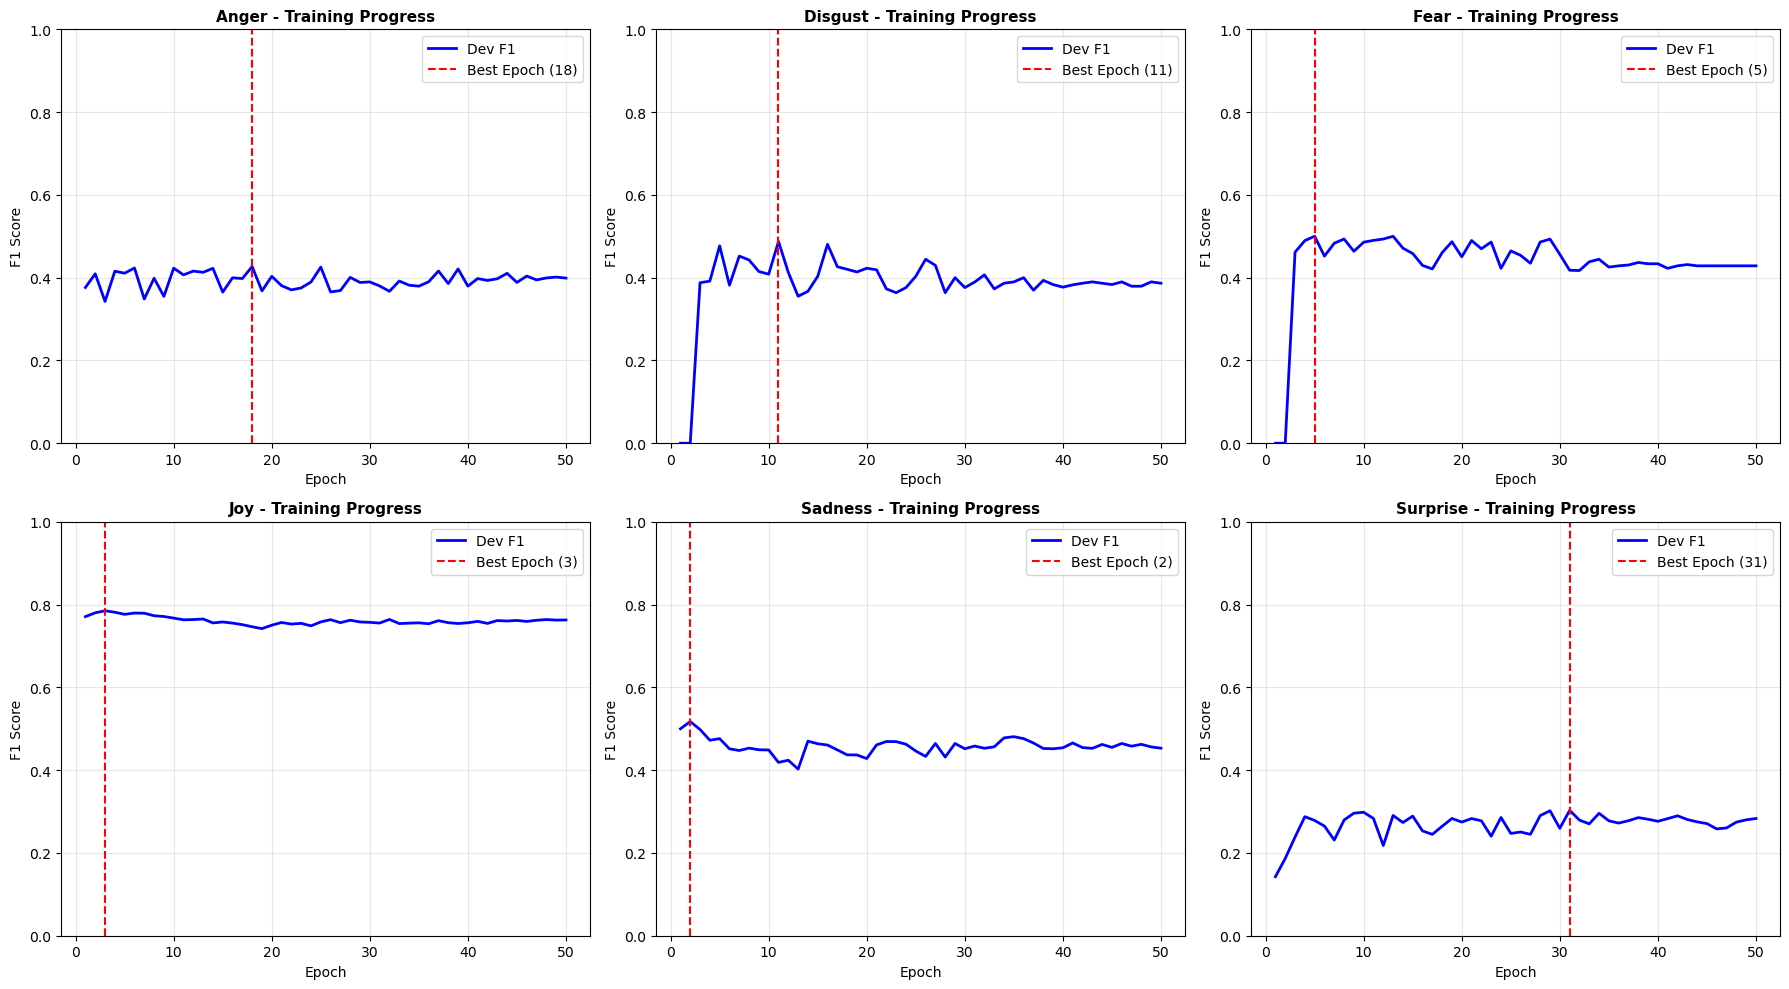

✓ Training history plot saved to results/training_history.png


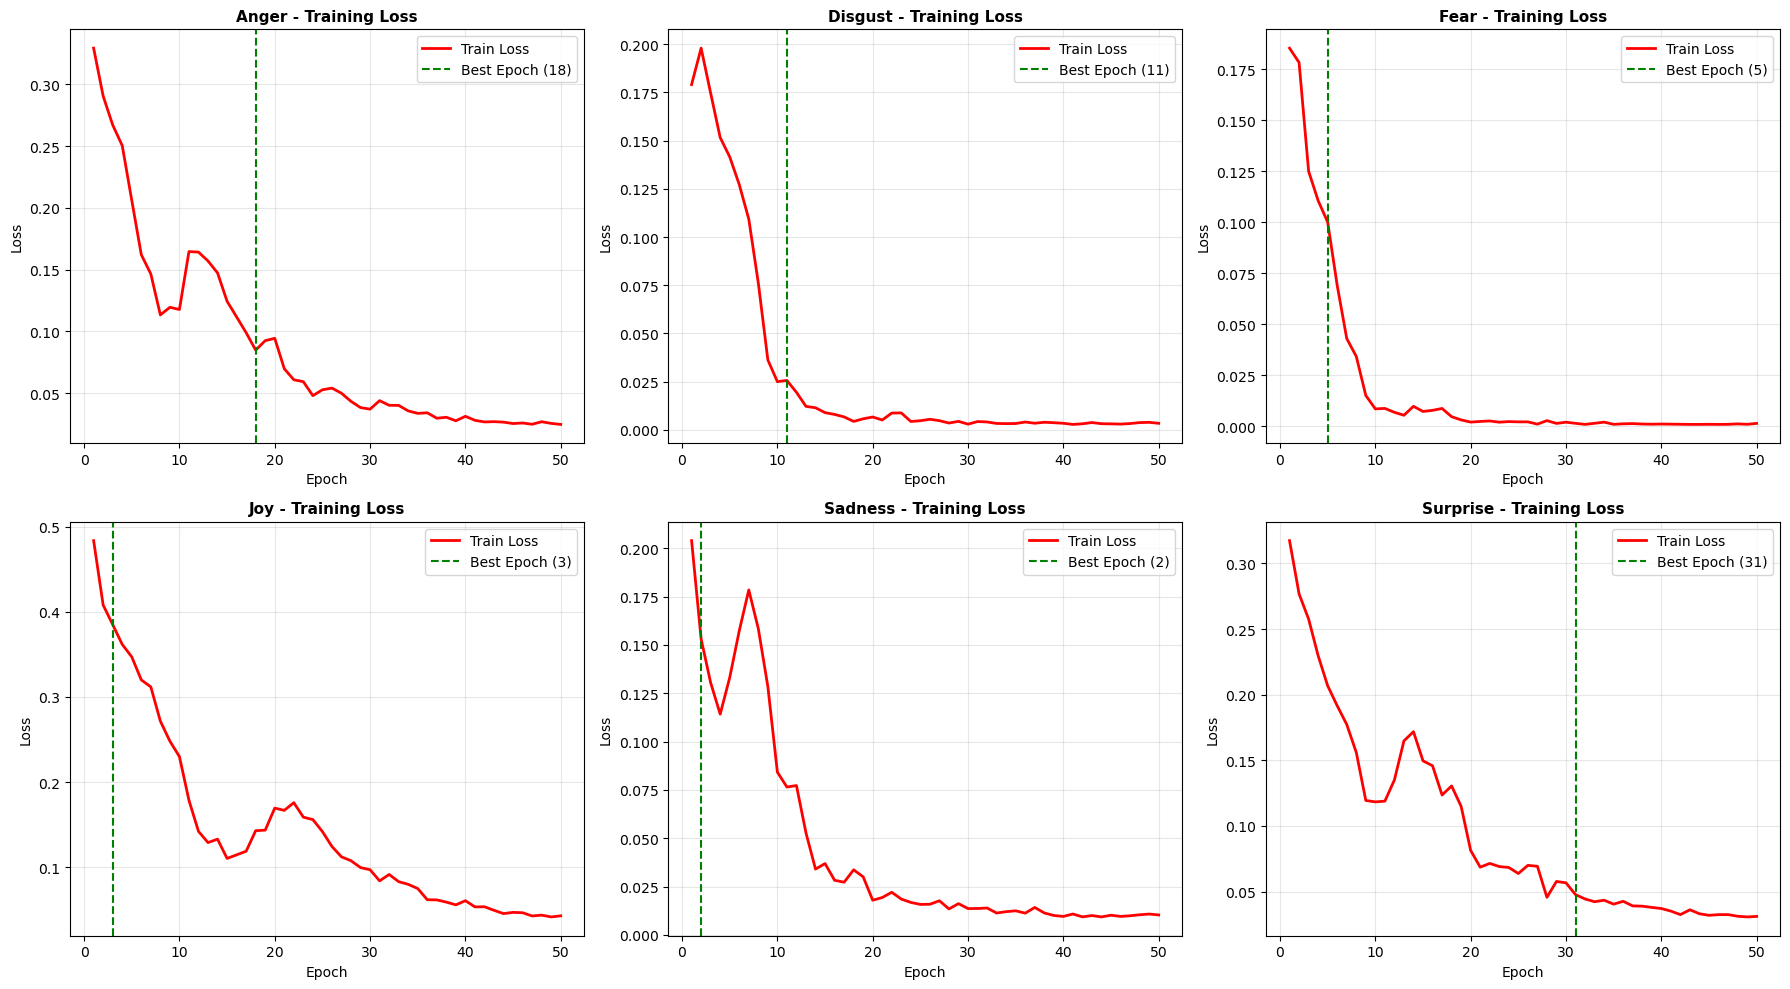

✓ Training loss plot saved to results/training_loss.png

Baseline Multi-class Training History


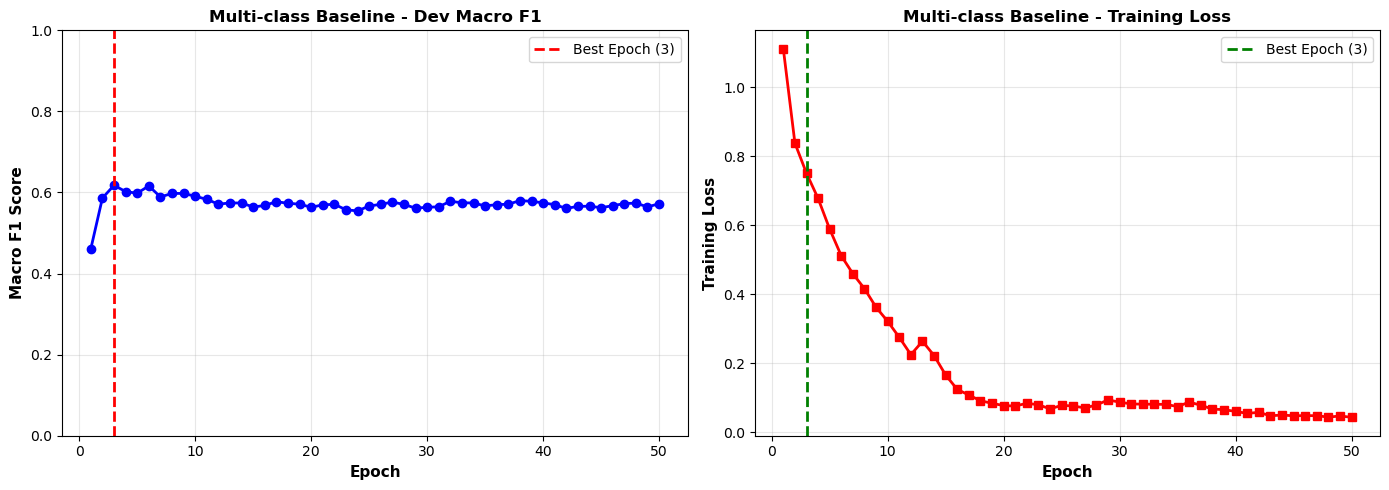

✓ Baseline history plot saved to results/baseline_history.png


In [10]:
# Step 9: Training History Visualization
print("="*60)
print("STEP 9: TRAINING HISTORY VISUALIZATION")
print("="*60)

# Plot training history for each emotion
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, emotion in enumerate(target_emotions):
    ax = axes[i]
    history = all_results[emotion]['history']
    
    epochs_range = range(1, FIXED_PARAMS['epochs'] + 1)
    
    # Plot F1 score
    ax.plot(epochs_range, history['dev_f1'], 'b-', label='Dev F1', linewidth=2)
    ax.axvline(all_results[emotion]['best_epoch'], color='r', linestyle='--', 
               label=f"Best Epoch ({all_results[emotion]['best_epoch']})", linewidth=1.5)
    
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('F1 Score', fontsize=10)
    ax.set_title(f'{emotion.capitalize()} - Training Progress', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved to results/training_history.png")

# Plot loss curves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, emotion in enumerate(target_emotions):
    ax = axes[i]
    history = all_results[emotion]['history']
    
    epochs_range = range(1, FIXED_PARAMS['epochs'] + 1)
    
    # Plot training loss
    ax.plot(epochs_range, history['train_loss'], 'r-', label='Train Loss', linewidth=2)
    ax.axvline(all_results[emotion]['best_epoch'], color='g', linestyle='--', 
               label=f"Best Epoch ({all_results[emotion]['best_epoch']})", linewidth=1.5)
    
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_title(f'{emotion.capitalize()} - Training Loss', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training loss plot saved to results/training_loss.png")

# Multi-class baseline history
print(f"\n{'='*60}")
print("Baseline Multi-class Training History")
print(f"{'='*60}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, FIXED_PARAMS['epochs'] + 1)

# Plot Macro F1
ax1.plot(epochs_range, history_mc['dev_macro_f1'], 'b-', linewidth=2, marker='o')
ax1.axvline(baseline_result['best_epoch'], color='r', linestyle='--', 
            label=f"Best Epoch ({baseline_result['best_epoch']})", linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Macro F1 Score', fontsize=11, fontweight='bold')
ax1.set_title('Multi-class Baseline - Dev Macro F1', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot Training Loss
ax2.plot(epochs_range, history_mc['train_loss'], 'r-', linewidth=2, marker='s')
ax2.axvline(baseline_result['best_epoch'], color='g', linestyle='--', 
            label=f"Best Epoch ({baseline_result['best_epoch']})", linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
ax2.set_title('Multi-class Baseline - Training Loss', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/baseline_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Baseline history plot saved to results/baseline_history.png")


In [11]:
# Step 10: Export Results to JSON
print("="*60)
print("STEP 10: EXPORT RESULTS")
print("="*60)

import json

# Compile all results for export
export_data = {
    'experiment_info': {
        'title': 'BERT Emotion Classification - Binary vs Multi-class',
        'dataset': 'GoEmotions (Ekman 6 emotions)',
        'architecture': 'BERT-base-uncased (12 layers, 12 heads, hidden=768)',
        'training_approach': 'Fixed hyperparameters (no tuning)',
        'data_balancing': 'None (original imbalanced data)',
        'preprocessing': 'Case folding, cleaning, normalization, stopword removal, stemming'
    },
    'hyperparameters': {
        'learning_rate': float(FIXED_PARAMS['learning_rate']),
        'batch_size': int(FIXED_PARAMS['batch_size']),
        'epochs': int(FIXED_PARAMS['epochs']),
        'weight_decay': float(FIXED_PARAMS['weight_decay']),
        'optimizer': 'AdamW',
        'scheduler': 'Linear warmup',
        'mixed_precision': True
    },
    'binary_models': {},
    'baseline_multiclass': {}
}

# Export binary models results
for emotion in target_emotions:
    result = best_models_per_emotion[emotion]
    export_data['binary_models'][emotion] = {
        'best_epoch': int(result['best_epoch']),
        'dev_metrics': {
            'f1': float(result['dev_metrics']['f1']),
            'precision': float(result['dev_metrics']['precision']),
            'recall': float(result['dev_metrics']['recall']),
            'accuracy': float(result['dev_metrics']['accuracy']),
            'roc_auc': float(result['dev_metrics']['roc_auc'])
        },
        'test_metrics': {
            'f1': float(result['test_metrics']['f1']),
            'precision': float(result['test_metrics']['precision']),
            'recall': float(result['test_metrics']['recall']),
            'accuracy': float(result['test_metrics']['accuracy']),
            'roc_auc': float(result['test_metrics']['roc_auc'])
        }
    }

# Export baseline results
export_data['baseline_multiclass'] = {
    'best_epoch': int(baseline_result['best_epoch']),
    'dev_macro_f1': float(baseline_result['dev_macro_f1']),
    'test_macro_f1': float(baseline_result['test_macro_f1']),
    'per_emotion_test_metrics': {}
}

for emotion in target_emotions:
    export_data['baseline_multiclass']['per_emotion_test_metrics'][emotion] = {
        'f1': float(baseline_metrics[emotion]['f1']),
        'precision': float(baseline_metrics[emotion]['precision']),
        'recall': float(baseline_metrics[emotion]['recall']),
        'accuracy': float(baseline_metrics[emotion]['accuracy'])
    }

# Calculate summary statistics
binary_f1_avg = np.mean([export_data['binary_models'][e]['test_metrics']['f1'] for e in target_emotions])
baseline_f1_avg = np.mean([export_data['baseline_multiclass']['per_emotion_test_metrics'][e]['f1'] for e in target_emotions])

export_data['summary'] = {
    'binary_models_avg_f1': float(binary_f1_avg),
    'baseline_avg_f1': float(baseline_f1_avg),
    'improvement_percentage': float(((binary_f1_avg - baseline_f1_avg) / baseline_f1_avg) * 100)
}

# Save to JSON
json_path = 'results/experiment_results.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(export_data, f, indent=4, ensure_ascii=False)

print(f"✓ Results exported to {json_path}")

# Display summary
print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)

print(f"\nHyperparameters (Fixed):")
print(f"  Learning Rate:    {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size:       {FIXED_PARAMS['batch_size']}")
print(f"  Epochs:           {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay:     {FIXED_PARAMS['weight_decay']}")

print(f"\nBinary Models Results:")
for emotion in target_emotions:
    result = export_data['binary_models'][emotion]
    print(f"  {emotion.capitalize():<12}: Best Epoch={result['best_epoch']:2d}, "
          f"Test F1={result['test_metrics']['f1']:.4f}, "
          f"Precision={result['test_metrics']['precision']:.4f}, "
          f"Recall={result['test_metrics']['recall']:.4f}")

print(f"\nBaseline Multi-class Results:")
print(f"  Best Epoch: {baseline_result['best_epoch']}")
print(f"  Test Macro F1: {baseline_result['test_macro_f1']:.4f}")
for emotion in target_emotions:
    metrics = export_data['baseline_multiclass']['per_emotion_test_metrics'][emotion]
    print(f"  {emotion.capitalize():<12}: F1={metrics['f1']:.4f}, "
          f"Precision={metrics['precision']:.4f}, "
          f"Recall={metrics['recall']:.4f}")

print(f"\nOverall Comparison:")
print(f"  Binary Models Avg F1:     {binary_f1_avg:.4f}")
print(f"  Baseline Avg F1:          {baseline_f1_avg:.4f}")
print(f"  Improvement:              {export_data['summary']['improvement_percentage']:+.2f}%")

print(f"\n{'='*80}")
print("All results saved to:")
print(f"  - results/experiment_results.json")
print(f"  - results/metrics_per_emotion.csv")
print(f"  - results/comparison_plot.png")
print(f"  - results/training_history.png")
print(f"  - results/training_loss.png")
print(f"  - results/baseline_history.png")
print(f"{'='*80}")


STEP 10: EXPORT RESULTS
✓ Results exported to results/experiment_results.json

EXPERIMENT RESULTS SUMMARY

Hyperparameters (Fixed):
  Learning Rate:    2e-05
  Batch Size:       32
  Epochs:           50
  Weight Decay:     0.01

Binary Models Results:
  Anger       : Best Epoch=18, Test F1=0.4170, Precision=0.4470, Recall=0.3909
  Disgust     : Best Epoch=11, Test F1=0.3594, Precision=0.5227, Recall=0.2738
  Fear        : Best Epoch= 5, Test F1=0.5584, Precision=0.6615, Recall=0.4831
  Joy         : Best Epoch= 3, Test F1=0.7834, Precision=0.7807, Recall=0.7861
  Sadness     : Best Epoch= 2, Test F1=0.4861, Precision=0.5955, Recall=0.4107
  Surprise    : Best Epoch=31, Test F1=0.3142, Precision=0.3647, Recall=0.2760

Baseline Multi-class Results:
  Best Epoch: 3
  Test Macro F1: 0.6203
  Anger       : F1=0.5850, Precision=0.6222, Recall=0.5521
  Disgust     : F1=0.5385, Precision=0.5833, Recall=0.5000
  Fear        : F1=0.6851, Precision=0.6739, Recall=0.6966
  Joy         : F1=0.8365